# Apartments

## Dane

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../apartments.csv')
data_test = pd.read_csv('../apartments_test.csv')

In [3]:
data.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [5]:
data.describe()

,m2.price,construction.year,surface,floor,no.rooms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000
std,906.691651,25.831511,37.874799,2.899876,1.381415
min,1607.000000,1920.000000,20.000000,1.000000,1.000000
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000
max,6595.000000,2010.000000,150.000000,10.000000,6.000000


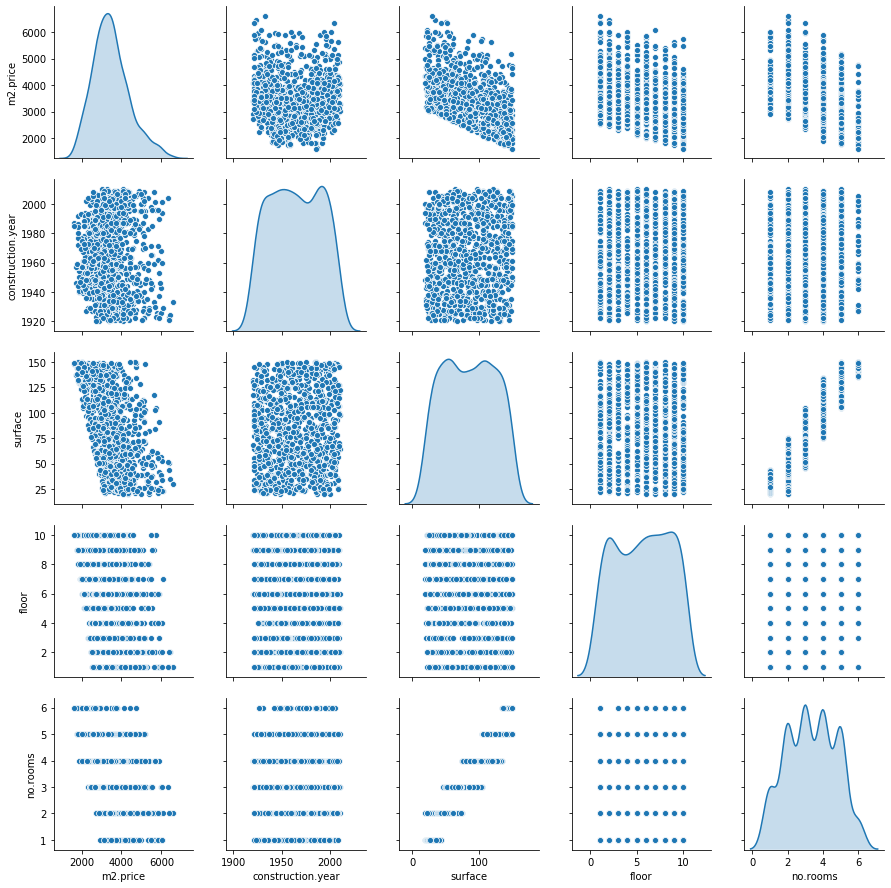

In [6]:
sns.pairplot(data, diag_kind='kde')

Text(0.5, 1, 'Korelacja zmiennych')

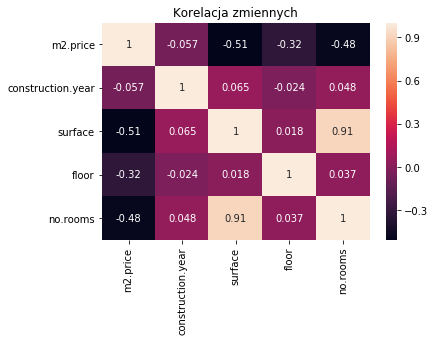

In [7]:
corr=data.corr()
ax=sns.heatmap(corr,
              xticklabels=corr.columns,
              yticklabels=corr.columns, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Korelacja zmiennych')

Od razu widać oczywistą korelację ilości pomieszczeń i powierzchni mieszkania.
Widać, że mało istotne jest ile lat ma mieszkanie.
Ciekawy jest fakt, że im większa powierzchnia, wyższe piętro i więcej pokoi tym tańsze jest mieszkanie.
Najprawdopodobniej wynika to z faktu, że w korelacjach nie uwzględanimy dzielnic. Nie jest zaskakujące, że mieszkania w centrum będą najdroższe nawet pomimo mniejszego metrażu.

## Przygotowanie danych

Braków nie ma, wystarczy zakodować zmienne kategoryczne.

In [8]:
import category_encoders as ce

In [9]:
data['district'].unique()

array(['Srodmiescie', 'Bielany', 'Praga', 'Ochota', 'Mokotow', 'Ursus',
       'Zoliborz', 'Wola', 'Bemowo', 'Ursynow'], dtype=object)

10 dzielnic, spokojnie można objąć One Hot encodingiem. Liczba kolumn wzrośnie nam jedynie do 15, a wierszy mamy tylko 1000 więc powinno to działać relatywnie szybko.

In [10]:
ohe = ce.OneHotEncoder(cols=['district'], use_cat_names=True)
ohe.fit(data)
data = ohe.transform(data)

In [11]:
data_test = ohe.transform(data_test)

In [12]:
X_train = data.drop('m2.price', axis = 1)
y_train = data['m2.price']
X_test = data_test.drop('m2.price', axis = 1)
y_test = data_test['m2.price']

## Model i uczenie bez strojenia

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [53]:
clf = SVR()
clf.fit(X_train, y_train)
mean_squared_error(y_test, clf.predict(X_test))

825769.4375092317

beznadziejnie to chyba mało powiedziane :)

## Strojenie random search

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [55]:
kernel=['rbf'] # jądro gaussowskie
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma = [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9, 1]
param_grid = dict(kernel=kernel, C = C, gamma = gamma)

In [60]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
random = RandomizedSearchCV(estimator=SVR(epsilon = 0.01), param_distributions=param_grid, cv = 4, n_jobs=-1)

In [61]:
random_result = random.fit(X_train, y_train)

In [63]:
print("Wyniki na zbiorze treningowym:")
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, random_result.cv_results_['params']):
    print("%0.3f (+/-%0.03f) dla %r"% (mean, std * 2, params))

Wyniki na zbiorze treningowym:
-0.014 (+/-0.026) dla {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.01}
0.094 (+/-0.030) dla {'kernel': 'rbf', 'gamma': 0.2, 'C': 10000}
-0.015 (+/-0.026) dla {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.001}
0.256 (+/-0.046) dla {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}
-0.014 (+/-0.026) dla {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
0.438 (+/-0.048) dla {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10000}
-0.009 (+/-0.025) dla {'kernel': 'rbf', 'gamma': 0.001, 'C': 0.1}
-0.015 (+/-0.026) dla {'kernel': 'rbf', 'gamma': 0.5, 'C': 1}
0.002 (+/-0.007) dla {'kernel': 'rbf', 'gamma': 0.9, 'C': 10000}
-0.014 (+/-0.026) dla {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.001}


Najlepsze wyniki dla **gamma: 0.9** **C: 10000**

## Dostosowanie modelu

In [50]:
clf = SVR(kernel = 'rbf', gamma = 0.9, C = 10000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.008683334849434066

I od razu o wiele lepiej, widać że teraz błąd jest naprawdę znikomy.